<a href="https://colab.research.google.com/github/arunmadhusud/3D-Object-Detection-From-Partial-Point-Clouds/blob/main/GRNet%2BPointnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup GRNet and dependencies

In [1]:
# import necessary packages
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import plotly.graph_objects as go
import plotly.express as px

In [2]:
#clone repository
!git clone https://github.com/hzxie/GRNet.git


Cloning into 'GRNet'...
remote: Enumerating objects: 932, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 932 (delta 161), reused 258 (delta 155), pack-reused 643
Receiving objects: 100% (932/932), 1.24 MiB | 4.11 MiB/s, done.
Resolving deltas: 100% (591/591), done.


In [ ]:
# update matplotlib and opend3d versions in requirements.txt file
%cd /content/GRNet
!sed -i 's/matplotlib==3.0.3/matplotlib==3.5.1/' requirements.txt
!sed -i 's/open3d==0.15.2/open3d==0.17.0/' requirements.txt
!pip install -r requirements.txt

In [ ]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import open3d as o3d

import plotly.graph_objects as go
import plotly.express as px

In [ ]:
# mount google drive. We have saved the dataset in google drive.
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
# Chamfer Distance
%cd /content/GRNet/extensions/chamfer_dist
!python setup.py install --user

In [ ]:
# Cubic Feature Sampling
%cd /content/GRNet/extensions/cubic_feature_sampling
!python setup.py install --user

In [ ]:
# Gridding & Gridding Reverse
%cd /content/GRNet/extensions/gridding
!python setup.py install --user

In [ ]:
# Gridding Loss
%cd /content/GRNet/extensions/gridding_loss
!python setup.py install --user

In [ ]:
#copy the dataset 'ShapeNetcompletion' from drive. The dataset can be  be downloaded from the link provided in README file
!cp -r /mydrive/ShapeNetCompletion.zip /content/

In [ ]:
# !rm -rf /content/shapenet/
# unzip shapenet
!unzip /content/ShapeNetCompletion.zip -d /content/shapenet

In [ ]:
%cd /content/GRNet/utils/
!pip install tensorpack

In [ ]:
!pip install lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 kB 6.8 MB/s eta 0:00:00


In [ ]:
#copy the pretrained weights from drive. We saved Pre-trained weights of GRNet in google drive. 

!cp -r /mydrive/GRNet-ShapeNet.pth /content/

In [ ]:
%cd /content/

/content


In [ ]:
# we used pre-trained model for inference. The completed pointclouds will be store at ./output/benchmark/
# Before running the inference, update the path of '__C.DATASETS.SHAPENET.CATEGORY_FILE_PATH' in config.py 
# Before running the inference, update the path of '__C.DATASETS.SHAPENET.PARTIAL_POINTS_PATH ' in config.py 
# Before running the inference, update the path of '__C.DATASETS.SHAPENET.COMPLETE_POINTS_PATH' in config.py 
!python3 /content/GRNet/runner.py --inference --weights=/content/GRNet-ShapeNet.pth

# Run PointNet on completed pointclouds using GRNet


## Install required dependencies to run PointNet

---




In [ ]:
%cd ./output

/content/output


In [ ]:
!pip install path.py;
from path import Path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
random.seed = 42

In [ ]:
!pip install open3d==0.17.0

In [ ]:
import open3d as o3d

## Define functions for visaulization and pre-processing of point clouds

In [ ]:
# function to visualize animated rotation of point clouds
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [ ]:
# function to display pointclouds
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [ ]:
# This part converts a '.h5' file to '.pcd' file.
import h5py
import numpy as np
import open3d as o3d
filename = "/content/output/benchmark/02691156/17874281e56ff0fbfca1f1143bb6bc17.h5"


with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    #print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    #print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array

    # convert ds_arr to numpy array
    data = np.array(ds_arr)
    print(data)

    # convert numpy array to point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data)   
    
    pcd.translate(-pcd.get_center())
    pcd.points = o3d.utility.Vector3dVector(np.asarray(pcd.points)/np.max(np.linalg.norm(np.asarray(pcd.points), axis=1)))
    completed_pointcloud = np.asarray(pcd.points)

    


   



[[ 0.07568029 -0.03727138  0.03878317]
 [ 0.14174047 -0.037436    0.03903884]
 [ 0.09246394 -0.03736169  0.03908024]
 ...
 [ 0.07213413 -0.09904017 -0.09520584]
 [ 0.04521886 -0.09200658 -0.09275183]
 [ 0.07649153 -0.09074472 -0.08735437]]


In [ ]:
# Display the completed point cloud
pcshow(*completed_pointcloud.T)

In [ ]:
# pre-process the point clouds: farthest down sampling, translate points to zero mean and normalize
def preprocess_point_cloud(pcd,num_points):
    num = len(pcd.points)
    if (num > num_points) :   
      pcd = pcd.farthest_point_down_sample(num_points)
    pcd.translate(-pcd.get_center())
    pcd.points = o3d.utility.Vector3dVector(np.asarray(pcd.points)/np.max(np.linalg.norm(np.asarray(pcd.points), axis=1)))
    return pcd

In [ ]:
# read a partial point cloud for visualization
pcd = o3d.geometry.PointCloud()
pcd= o3d.io.read_point_cloud('/content/shapenet/test/partial/02691156/17874281e56ff0fbfca1f1143bb6bc17/00.pcd')
pcd = preprocess_point_cloud(pcd,2000)
pointcloud = np.asarray(pcd.points)

In [ ]:
# visualize partial point clouds
pcshow(*pointcloud.T)

In [ ]:
# convert to Tensor
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        return torch.from_numpy(pointcloud.astype(np.float64))

In [ ]:
# define transforms
train_transform = transforms.Compose([ToTensor()])

In [ ]:
# define default tranforms if user isn't passing a tranform for training
def default_transforms():
    return transforms.Compose([                             
                                ToTensor()
                              ])

## Testing Data Creation. 





In [ ]:
# define the function to generate test dataset. This function reads the completed pointclouds by GRNet architecture
class CompletedPointCloud(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms(),num_points = 2048):
        # this is outpput folder
        self.root_dir = root_dir
        # print (self.root_dir)
        # this gives benchmark folder
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        # print("folders:\n")
        # print (folders)
        # this gives all the categories
        self.classes = {folder: i for i, folder in enumerate(folders)}
        # self.classes = {folder: i for i, folder in enumerate(self.root_dir)}
        # print("classes:\n")
        # print(self.classes)
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.num_points = num_points
        # print(self.num_points)
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)            
            # print(new_dir)
            for file in os.listdir(new_dir):
                if file.endswith('.h5'):
                    sample = {}
                    sample['h5_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)
        # print(self.files[0])
    def __len__(self):
        return len(self.files)
    
    '''
    Convert h5 files to pcd
    '''
    def __preproc__(self, file):
        if self.transforms:           
            with h5py.File(file.name, "r") as f:
                # Print all root level object names (aka keys) 
                # these can be group or dataset names 
                # print("Keys: %s" % f.keys())
                # get first object name/key; may or may NOT be a group
                a_group_key = list(f.keys())[0]

                # get the object type for a_group_key: usually group or dataset
                # print(type(f[a_group_key])) 

                # If a_group_key is a group name, 
                # this gets the object names in the group and returns as a list
                data = list(f[a_group_key])

                # If a_group_key is a dataset name, 
                # this gets the dataset values and returns as a list
                data = list(f[a_group_key])
                # preferred methods to get dataset values:
                ds_obj = f[a_group_key]      # returns as a h5py dataset object
                ds_arr = f[a_group_key][()]  # returns as a numpy array

                # convert ds_arr to numpy array
                # convert ds_arr to numpy array
                data = np.array(ds_arr)
                # print(data)

                # convert numpy array to point cloud
                pcd = o3d.geometry.PointCloud()
                pcd.points = o3d.utility.Vector3dVector(data)

                num = len(pcd.points)
                if (num > self.num_points) :   
                  pcd = pcd.farthest_point_down_sample(self.num_points)              
                
                pcd.translate(-pcd.get_center())
                pcd.points = o3d.utility.Vector3dVector(np.asarray(pcd.points)/np.max(np.linalg.norm(np.asarray(pcd.points), axis=1)))
                completed_pointcloud = np.asarray(pcd.points)
                completed_pointcloud = self.transforms(completed_pointcloud)
        return completed_pointcloud
    
    def __getitem__(self, idx):
        pcd_path = self.files[idx]['h5_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
%cd /content

/content


In [ ]:
# for completed point clouds
path = Path("output/benchmark")
print(path)

output/benchmark


In [ ]:
valid_ds = CompletedPointCloud(path, valid = True, folder = 'test', transform = train_transform, num_points = 2048)

In [ ]:
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)
print(len(valid_loader))

19


## PointNet Model

In [ ]:
# Define PointNet model
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
# define loss function
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
pointnet = PointNet()
pointnet.to(device);

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

## Test the Model and generate confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('/content/save_14.pth'))
pointnet.eval();

In [ ]:

all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        # print(preds)
        # print(list(preds.numpy()))
        # print(list(labels.numpy()))
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        # print(all_preds)
        # print(all_labels)
        # preds = [category_map[pred] for pred in preds.item()]
        # labels = [category_map[label] for label in labels.item()]

In [ ]:
cm = confusion_matrix(all_labels, all_preds)[:8, :8]

cm

array([[145,   0,   2,   0,   0,   1,   0,   2],
       [  0, 143,   1,   0,   4,   0,   2,   0],
       [  0,   0, 150,   0,   0,   0,   0,   0],
       [  0,   1,   2, 138,   2,   5,   2,   0],
       [  0,   3,   1,   0, 138,   0,   2,   6],
       [  1,   0,   0,   8,   0, 135,   6,   0],
       [  0,  11,   0,   2,   2,   0, 135,   0],
       [  0,   0,   7,   1,   3,   0,   0, 139]])

In [ ]:
category_map = {
    '02691156': 'Plane',
    '02933112': 'Cabinet',
    '02958343': 'Car',
    '03001627': 'Chair',
    '03636649': 'Lamp',
    '04256520': 'Sofa',
    '04379243': 'Table',
    '04530566': 'Watercraft'
}

In [ ]:
element_names = list(category_map.values())

In [ ]:
# function to display confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


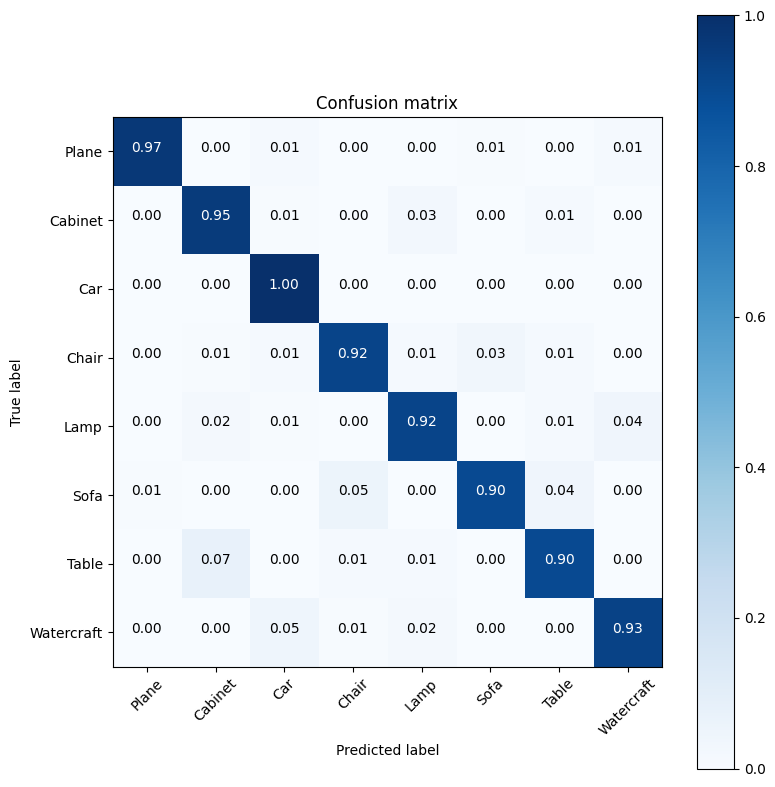

In [ ]:
# plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, element_names, normalize=True)

Confusion matrix, without normalization


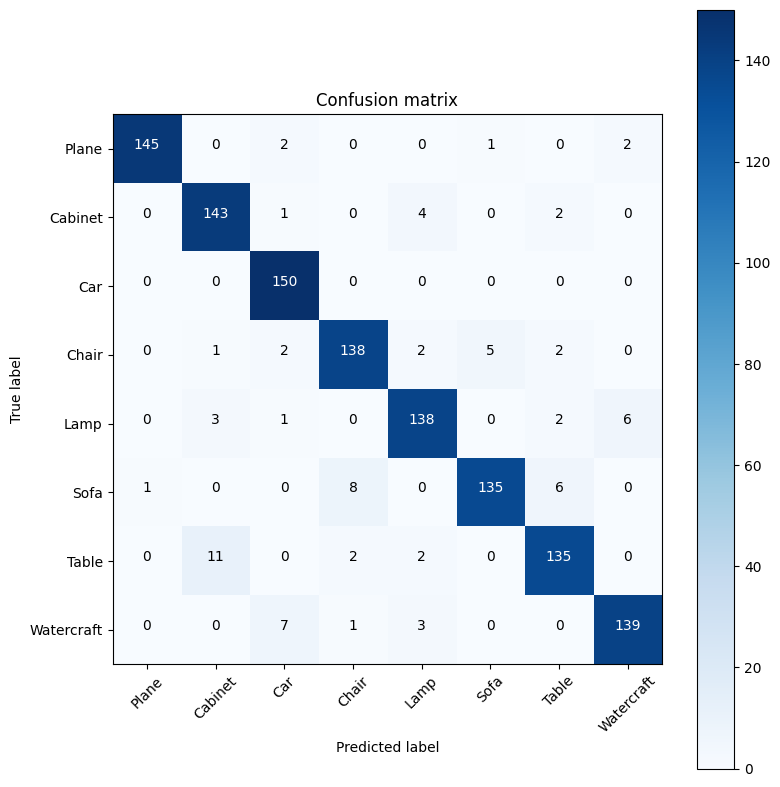

In [ ]:
# plot confusion matrix without normalization
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, element_names, normalize=False)